# Test EV control

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from ev_ssm import ev_ssm
from tqdm import tqdm

In [2]:
%run -i 'cosim_import.py'

0.post4467.dev0+g7d341a1
2.8.0


In [3]:
caseH = 18
%run -i 'cosim_setup_andes.py'

EVA: ts=18[H], 50000 EVs, Total Q=434.64 MWh
Online 14481, Q=361.83 MWh, SoC=0.7687
Power(MW): Pt=-39.9433, Pc=-39.9433, Pd=-0.0
Ctrl: 0=7778; 1=6703; 
EVA: Load A from Aest.csv.
Working directory: "/Users/jinningwang/Documents/work/andes/jwang/notes"
> Loaded config from file "/Users/jinningwang/.andes/andes.rc"
> Loaded generated Python code in "/Users/jinningwang/.andes/pycode".
Generated code for <PQ> is stale.
Numerical code generation (rapid incremental mode) started...


Generating code for 1 models on 8 processes.


Saved generated pycode to "/Users/jinningwang/.andes/pycode"
> Reloaded generated Python code of module "pycode".
Generated numerical code for 1 models in 0.1465 seconds.
Parsing input file "/Users/jinningwang/Documents/work/andes/jwang/case/ieee39_ev2.xlsx"...
Input file parsed in 0.0728 seconds.
System internal structure set up in 0.0239 seconds.


In [4]:
%run -i 'cosim_loadsyn.py'

ANDES total load is: 58.564 p.u.


In [5]:
%run -i 'cosim_setup_dispatch.py'

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.1014 seconds.
0: |F(x)| = 7.561234474
1: |F(x)| = 2.917099456
2: |F(x)| = 0.1313037751
3: |F(x)| = 0.0003572374622
4: |F(x)| = 4.286882849e-09
Converged in 5 iterations in 0.0044 seconds.
Power flow results are consistent. Conversion is successful.


Set parameter Username
Academic license - for non-commercial use only - expires 2023-04-08


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0040 seconds.
0: |F(x)| = 7.561234474
1: |F(x)| = 2.917099456
2: |F(x)| = 0.1313037751
3: |F(x)| = 0.0003572374622
4: |F(x)| = 4.286882849e-09
Converged in 5 iterations in 0.0034 seconds.
Power flow results are consistent. Conversion is successful.
GSF is consistent.
RTED GB model is loaded.
RTED removed: ['rampu', 'rampd']
RTED limited: sfru, sfrd
RTED: total cost=4910.307


pp cost=2224.8754288341015, gb cost=4910.307428177316


In [6]:
%run -i 'cosim_linktable.py'

In [7]:
# Change ``rru``, ``rrd``, ``rsfr``, ``t_total`` for necessary.
t_total = 3600

rru, rrd, rsfr = 1.0, 1.0, 0.04

# Define functions and constants used in loop
%run -i 'cosim_const.py'

Analyze the data to initialize the number of actions.

In [8]:
# read data from previous run
evsr1 = pd.read_csv('cosim_18_F_evsoc1.csv')
evsr2 = pd.read_csv('cosim_18_F_evsoc2.csv')
evd = pd.read_csv('cosim_18_F_evdata.csv').iloc[ridx].reset_index(drop=True)
eva = pd.read_csv('cosim_18_F_evagc.csv')
eva.columns = range(t_total)

evs = pd.concat([evsr1, evsr2], ignore_index=True)

In [9]:
col = list(range(0, 3600, 4))

In [10]:
# reconstruct the EV Ctrl signal
evc = pd.DataFrame(-2*np.ones((1600, 900)), columns=col)
evc[0] = evd['c']

for i in range(4, t_total, 4):
    evc[i] = evc[i-4] - eva[i]
    if evc[i].max() > 1:
        print(i)

324
328
332
336
340
344
348
352
356
484
488
492
496
500
504
508
512
516
520
524
528
532
536
540
544
548
552
556
560
564
568
572
576
580
584
588
592
596
600
604
608
612
616
620
624
628
632
636
640
644
648
652
656
660
664
668
672
676
680
684
688
692
696
700
704
708
712
716
720
724
728
732
736
740
744
748
752
756
760
764
768
772
776
780
784
788
792
796
800
804
808
812
816
820
824
828
832
836
840
844
848
852
856
860
864
868
872
876
880
884
888
892
896
900
904
908
912
916
920
924
928
932
936
940
944
948
952
956
960
964
968
972
976
980
984
988
992
996
1000
1004
1008
1012
1016
1020
1024
1028
1032
1036
1040
1044
1048
1052
1056
1060
1064
1068
1072
1076
1080
1084
1088
1092
1096
1100
1104
1108
1112
1116
1120
1124
1128
1132
1136
1140
1144
1148
1152
1156
1160
1164
1168
1172
1176
1180
1184
1188
1192
1196
1200
1204
1208
1212
1216
1220
1224
1228
1232
1236
1240
1244
1248
1252
1256
1260
1264
1268
1272
1276
1280
1284
1288
1292
1296
1300
1304
1308
1312
1316
1320
1324
1328
1332
1336
1340
1344
1348
1352
135

In [11]:
# build the EV NA
evna = pd.DataFrame(np.zeros((1600, 900)), columns=col)
for i in range(4, t_total, 4):
    evna[i] = evs[str(i)] <= 0.96 # this time using 0.96 rather than 'socd'
    evna[i] = evna[i].astype(int)
    evna[i] = evna[i] - evc[i]

In [32]:
evds = evd[['soc', 'soci', 'socd', 'ts', 'tf', 'sx']].reset_index(drop=True)
evds['na'] = evna[list(range(4, 900, 4))].sum(axis=1).values * 4
evds['tl'] = evds['tf'] - 18

<AxesSubplot:>

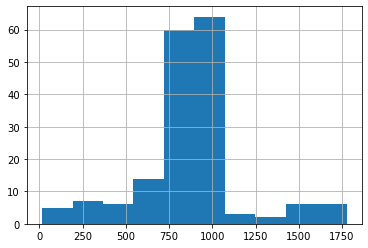

In [48]:
evds[evds['sx']==17]['na'].hist()

<AxesSubplot:>

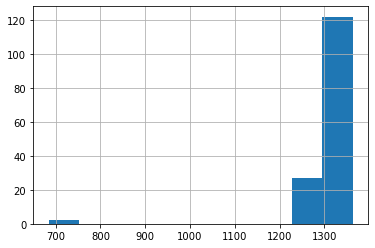

In [38]:
evds[evds['sx']==14]['na'].hist()

<AxesSubplot:>

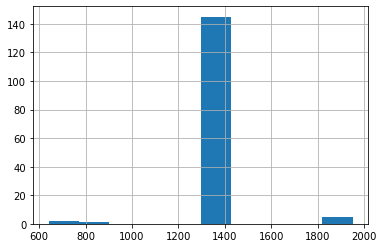

In [37]:
evds[evds['sx']==15]['na'].hist()

<AxesSubplot:>

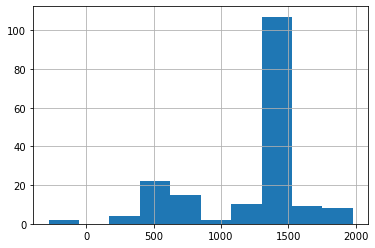

In [36]:
evds[evds['sx']==16]['na'].hist()

<AxesSubplot:>

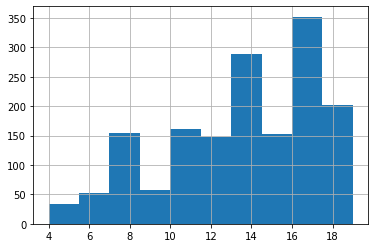

In [33]:
evds.sx.hist()

In [19]:
evds[evds['na'] < 0]

,soc,soci,socd,ts,tf,na
699,0.848334,0.321446,0.815896,15.405608,23.293317,-280.0
814,0.643983,0.214310,0.795026,17.003567,23.931944,-136.0
1034,0.599433,0.299276,0.828717,16.921475,22.471922,-164.0
1190,0.844449,0.271127,0.801323,15.796160,21.285086,-208.0


<AxesSubplot:>

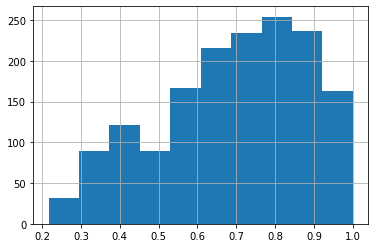

In [30]:
evds.soc.hist()

<AxesSubplot:xlabel='tl', ylabel='soc'>

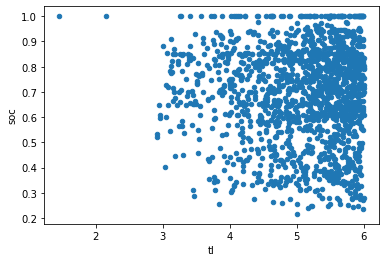

In [27]:
evds.plot.scatter(x='tl', y='soc')

In [ ]:
evna[list(range(4, 900, 4))].sum(axis=1)

Revise the EV control logic as: C->I, I->D, SOC high to low

In [ ]:
# --- Response ---

sse = ev_ssm(ts=18, N=10000, step=1, tp=40,
             lr=0.1, lp=40, seed=2022, name="EVA")
sse.load_A("Aest.csv")


In [ ]:
sse.ev['Qa'] = (sse.ev['tf'] - sse.ev['ts']) * sse.ev['Pc'] * sse.ev['nc'] - sse.ev['socd'] * sse.ev['Q']
sse.ev['Qr'] = sse.ev['Qa'].mean() + sse.ev['tt'] * sse.ev['Pd']
sse.ev['nr'] = sse.ev['Qr'] / sse.ev['Pc'] / sse.ev['nc'] * 3600 / 4

sse.ev['nr'].hist()

sse.ev['Qa'].mean()

In [ ]:
# --- Response ---

sse = ev_ssm(ts=10.4, N=10000, step=1, tp=40,
             lr=0.1, lp=40, seed=2022, name="EVA")
sse.load_A("Aest.csv")

x0 = sse.x0.copy()
print(sse.Prc)
sse.run(tf=10.4 + 2/3600, Pi=9,
        is_updateA=False, is_rstate=True,
        is_test=False, disable=False)
print(sse.Prc)
x1 = sse.x0.copy()

In [ ]:
plt.bar(range(len(x0)), x0, label="x0")
plt.bar(range(len(x0)), x1, label="x0", alpha=0.5)

In [ ]:
sse = ev_ssm(ts=10.4, N=10000, step=1, tp=40,
             lr=0.1, lp=40, seed=2022, name="EVA",
             is_report=False)

# historical data
ev_num = pd.read_csv("ev_num.csv")

# calculate the sf
k1 = ev_num['ne'][(ev_num['time'] >= sse.ts) & (ev_num['time'] <= sse.ts+1/12)].mean()
k0 = ev_num['ne'][ev_num['time'] >= sse.ts].iloc[0]
k = k1 / k0

# estiamte FRC
sse.g_frc(nea=sse.ne*k)

In [ ]:
## Run to get the EV numbers within a day

# import joblib
# from joblib import Parallel, delayed

# Nt = 10000
# def rne(time):
#     sse1 = ev_ssm(ts=time, N=Nt, step=1, tp=40,
#                   lr=0.1, lp=60, seed=2022, name="EVA",
#                   is_report=False)
#     return sse1.ne

# # interval by minutes, 24H
# rnel = Parallel(n_jobs=joblib.cpu_count())(delayed(rne)(i) for i in np.arange(1/60, 24, 1/60))

# ev_num = pd.DataFrame()
# ev_num['time'] = np.arange(1/60, 24, 1/60)
# ev_num['ne'] = rnel
# ev_num.to_csv("ev_num.csv", index=False)